In [107]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

Data Exploration

In [14]:
training_data = pd.read_csv('/Users/a/DataFest/Data/train_ScotiaDSD.csv')
testing_data = pd.read_csv('/Users/a/DataFest/Data/test_ScotiaDSD.csv')

/Users/a/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

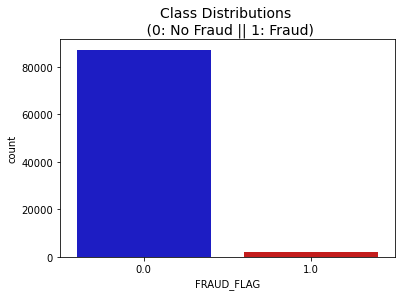

In [4]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('FRAUD_FLAG', data=training_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Unbalanced Dataset

In [15]:
# numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
training_num = training_data.select_dtypes(include=numerics)
testing_num = testing_data.select_dtypes(include=numerics)
training_num.head()

,EVENT_MONTH,EVENT_DAY_OF_WEEK,FRAUD_FLAG,AVAIL_CRDT,AMOUNT,CREDIT_LIMIT,CARD_NOT_PRESENT,FLAG_LX,FLAG_ATM,FLAG_AUTO,...,COUNT_LOW_AMT_PAST_30DAY,COUNT_MANUAL_ENTRY_PAST_30DAY,COUNT_PHONE_ORDER_PAST_30DAY,COUNT_PURCHASE_EXCLUDING_GAS_PAST_30DAY,COUNT_PLANNED_PAST_30DAY,COUNT_SWIPE_PAST_30DAY,COUNT_TRAVEL_AND_ENTERTAINMENT_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY,PREV_M_INFLATION,PREV_M_UNEMP_RATE
0,2,4,1.0,537.10,11.70,29200.0,1,0,0,1,...,16,39,73,60,13,22,4,14,1.1,5.7
1,2,4,0.0,20371.88,96.35,30700.0,1,0,0,0,...,1,50,93,93,0,0,0,0,1.1,5.7
2,2,4,0.0,15628.17,193.72,19500.0,0,0,0,0,...,9,3,42,42,2,33,0,12,1.1,5.7
3,2,4,0.0,12913.98,47.15,18400.0,0,0,0,0,...,4,7,75,72,12,61,0,20,1.1,5.7
4,2,4,0.0,26779.35,121.88,29200.0,1,0,0,0,...,11,6,41,42,10,30,4,16,1.1,5.7


In [16]:
# transform event_time to numerical value
time_training = training_data.loc[:,'EVENT_TIME']
time_training = time_training.str.split(':')
time_testing = testing_data.loc[:,'EVENT_TIME']
time_testing = time_testing.str.split(':')
for i in range(0,training_data.shape[0]):
    training_data['EVENT_TIME'][i] = int(time_training[i][0])*60 + int(time_training[i][1])
for i in range(0,testing_data.shape[0]):
    testing_data['EVENT_TIME'][i] = int(time_testing[i][0])*60 + int(time_testing[i][1])

/var/folders/2w/lpx6lqtd43d6dmbwlnm65f5h0000gn/T/ipykernel_29627/582672639.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['EVENT_TIME'][i] = int(time_training[i][0])*60 + int(time_training[i][1])
/var/folders/2w/lpx6lqtd43d6dmbwlnm65f5h0000gn/T/ipykernel_29627/582672639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['EVENT_TIME'][i] = int(time_testing[i][0])*60 + int(time_testing[i][1])


In [20]:
training_data['EVENT_TIME'] = pd.to_numeric(training_data['EVENT_TIME'])
testing_data['EVENT_TIME'] = pd.to_numeric(testing_data['EVENT_TIME'])

Analysis of non-numerical variable

<AxesSubplot:title={'center':'Percentage of Fraud for City'}, xlabel='City', ylabel='Percentage of Fraud'>

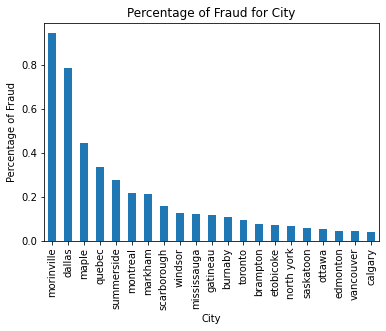

In [23]:
city_non_null = training_data[training_data['CITY'].notna()]
city = city_non_null[city_non_null['FRAUD_FLAG'] == 1]
city_counts = Counter(city['CITY'])
city_counts = dict(sorted(city_counts.items(), key=lambda item: item[1], reverse=True))
city_counts = dict(itertools.islice(city_counts.items(), 21))

total_city = training_data[training_data['CITY'].notna()]
total_city = Counter(total_city['CITY'])
city_counts_pert = {}
for key in city_counts.keys():
    city_counts_pert[key] = city_counts[key]/total_city[key]
city_counts_pert = dict(sorted(city_counts_pert.items(), key=lambda item: item[1], reverse=True))
pd.Series(city_counts_pert).plot(kind='bar',xlabel='City', ylabel='Percentage of Fraud', title='Percentage of Fraud for City')

<AxesSubplot:title={'center':'Percentage of Fraud for User Agent'}, xlabel='User Agent', ylabel='Percentage of Fraud'>

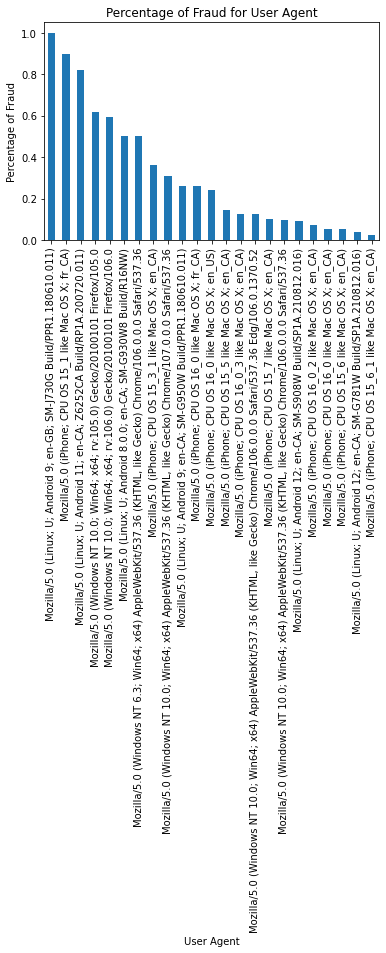

In [24]:
user_non_null = training_data[training_data['USER_AGENT'].notna()]
user = user_non_null[user_non_null['FRAUD_FLAG'] == 1]
user_counts = Counter(user['USER_AGENT'])
user_counts = dict(sorted(user_counts.items(), key=lambda item: item[1], reverse=True))
user_counts = dict(itertools.islice(user_counts.items(), 23))

total_user = training_data[training_data['USER_AGENT'].notna()]
total_user = Counter(total_user['USER_AGENT'])
user_counts_pert = {}
for key in user_counts.keys():
    user_counts_pert[key] = user_counts[key]/total_user[key]
user_counts_pert = dict(sorted(user_counts_pert.items(), key=lambda item: item[1], reverse=True))
pd.Series(user_counts_pert).plot(kind='bar',xlabel='User Agent', ylabel='Percentage of Fraud', title='Percentage of Fraud for User Agent')

Analysis of numerical variables

In [39]:
# numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
training_num = training_data.select_dtypes(include=numerics)
testing_num = testing_data.select_dtypes(include=numerics)
training_num.head()

,EVENT_MONTH,EVENT_DAY_OF_WEEK,EVENT_TIME,FRAUD_FLAG,AVAIL_CRDT,AMOUNT,CREDIT_LIMIT,CARD_NOT_PRESENT,FLAG_LX,FLAG_ATM,...,COUNT_LOW_AMT_PAST_30DAY,COUNT_MANUAL_ENTRY_PAST_30DAY,COUNT_PHONE_ORDER_PAST_30DAY,COUNT_PURCHASE_EXCLUDING_GAS_PAST_30DAY,COUNT_PLANNED_PAST_30DAY,COUNT_SWIPE_PAST_30DAY,COUNT_TRAVEL_AND_ENTERTAINMENT_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY,PREV_M_INFLATION,PREV_M_UNEMP_RATE
0,2,4,856,1.0,537.10,11.70,29200.0,1,0,0,...,16,39,73,60,13,22,4,14,1.1,5.7
1,2,4,771,0.0,20371.88,96.35,30700.0,1,0,0,...,1,50,93,93,0,0,0,0,1.1,5.7
2,2,4,926,0.0,15628.17,193.72,19500.0,0,0,0,...,9,3,42,42,2,33,0,12,1.1,5.7
3,2,4,979,0.0,12913.98,47.15,18400.0,0,0,0,...,4,7,75,72,12,61,0,20,1.1,5.7
4,2,4,495,0.0,26779.35,121.88,29200.0,1,0,0,...,11,6,41,42,10,30,4,16,1.1,5.7


In [69]:
# standardlize all numeric variables
scaler = StandardScaler()
scaler.fit_transform(training_num)
training_num_scaled = scaler.transform(training_num)
training_num_scaled = pd.DataFrame(training_num_scaled, columns = training_num.columns.to_list())
testing_num_scaled = scaler.transform(testing_num)
testing_num_scaled = pd.DataFrame(testing_num_scaled, columns = testing_num.columns.to_list())
# training_num_scaled

In [70]:
x_train_num = training_num.loc[:, ~training_num_scaled.columns.isin(['TRANSACTION_ID', 'FRAUD_FLAG'])]
y_train = training_num.loc[:, 'FRAUD_FLAG']
x_test_num = testing_num.loc[:, ~training_num_scaled.columns.isin(['TRANSACTION_ID', 'FRAUD_FLAG'])]
y_test = testing_num.loc[:, 'FRAUD_FLAG']

In [71]:
x_sub_train, x_sub_test, y_sub_train, y_sub_test = train_test_split(x_train_num, y_train,
                                                                   test_size = 0.33, 
                                                                   random_state = 42)

Oversampling and undersampling

In [81]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

oversample = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.95)

steps = [('o', oversample), ('u', under)]
pipeline = Pipeline(steps=steps)
train_X, train_y = pipeline.fit_resample(x_sub_train, y_sub_train.ravel())

Model: XGBoost

In [53]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4], 'n_estimators':[100]}    # parameters to be tries in the grid search
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [54]:
csv.fit(x_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, m...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3, 4],
                         'n_estimators': [100]},
             scoring='f1')

In [55]:
csv.best_params_

{'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100}

In [85]:
xg = xgb.XGBClassifier(max_depth=6, min_child_weight=3, n_estimators=100, eval_metric = 'auc')
xg.fit(train_X, train_y)
y_pred_s_xgb = xg.predict(x_sub_test)

In [103]:
print("Accuracy of prediction:",metrics.accuracy_score(y_sub_test, y_pred_s_xgb))
print("F1 score of prediction:", metrics.f1_score(y_sub_test, y_pred_s_xgb))
print("ROC AUC score of prediction:", metrics.roc_auc_score(y_sub_test, y_pred_s_xgb))
print("R2 score of prediction:", metrics.r2_score(y_sub_test, y_pred_s_xgb))

Accuracy of prediction: 0.9770427222712762
F1 score of prediction: 0.5710659898477157
ROC AUC score of prediction: 0.8118249042993663
R2 score of prediction: 0.01761434538496287


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     28741
         1.0       0.52      0.64      0.57       705

    accuracy                           0.98     29446
   macro avg       0.75      0.81      0.78     29446
weighted avg       0.98      0.98      0.98     29446



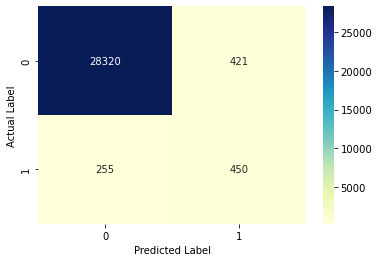

In [87]:
cnf_matrix = confusion_matrix(y_sub_test, y_pred_s_xgb)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_sub_test, y_pred_s_xgb))

Text(0.5, 1.0, 'Precision Recall Curve')

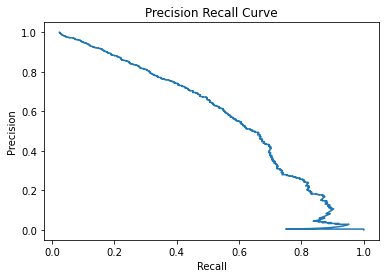

In [88]:
y_pred_prob = xg.predict_proba(x_sub_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_sub_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

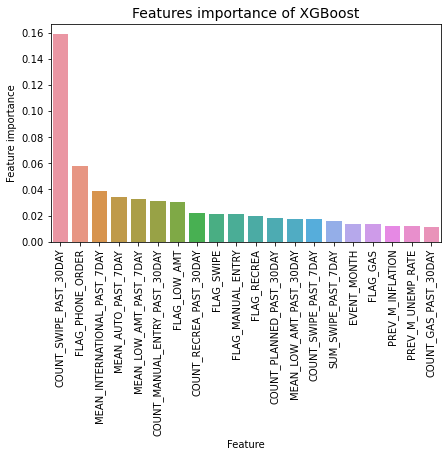

In [90]:
tmp = pd.DataFrame({'Feature': x_sub_train.columns.to_list(), 'Feature importance': xg.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance of XGBoost',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp.iloc[:20,:])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

In [93]:
y_pred = xg.predict(x_test_num)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
prob = xg.predict_proba(x_test_num)
df = pd.DataFrame(prob, columns = ['True','False'])
y_prob = df.iloc[:,0]

Id = testing_data['TRANSACTION_ID']
result = pd.DataFrame()
result['TRANSACTION_ID'] = testing_data['TRANSACTION_ID']
result['PREDICTION'] = y_pred
result['PROBABILITY'] = y_prob
for index in range(0,result.shape[0]):
    if result.iloc[index, 1] == 0:
        result.iloc[index, 2] = 1 - result.iloc[index, 2]
result.to_csv('/Users/a/DataFest/Data/result.csv')

Random Forest

In [102]:
rf = RandomForestClassifier(n_estimators=150, min_samples_split= 2)
rf.fit(train_X, train_y)
y_pred_rf = rf.predict(x_sub_test)

In [104]:
print("Accuracy of prediction:",metrics.accuracy_score(y_sub_test, y_pred_rf))
print("F1 score of prediction:", metrics.f1_score(y_sub_test, y_pred_rf))
print("ROC AUC score of prediction:", metrics.roc_auc_score(y_sub_test, y_pred_rf))
print("R2 score of prediction:", metrics.r2_score(y_sub_test, y_pred_rf))

Accuracy of prediction: 0.9726618216396115
F1 score of prediction: 0.5256334708308781
ROC AUC score of prediction: 0.8068134310808613
R2 score of prediction: -0.16985273959335045


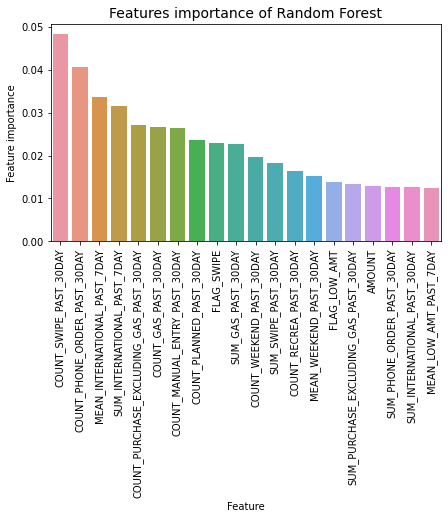

In [105]:
tmp = pd.DataFrame({'Feature': x_sub_train.columns.to_list(), 'Feature importance': rf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance of Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp.iloc[:20,:])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

AdaBooster

In [108]:
abc = AdaBoostClassifier(random_state=2022,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=100)
abc.fit(train_X, train_y)
y_pred_abc = abc.predict(x_sub_test)

In [109]:
print("Accuracy of prediction:", metrics.accuracy_score(y_sub_test, y_pred_abc))
print("F1 score of prediction:", metrics.f1_score(y_sub_test, y_pred_abc))
print("ROC AUC score of prediction:", metrics.roc_auc_score(y_sub_test, y_pred_abc))
print("R2 score of prediction:", metrics.r2_score(y_sub_test, y_pred_abc))

Accuracy of prediction: 0.9570739659036881
F1 score of prediction: 0.4009478672985782
ROC AUC score of prediction: 0.7829163912181205
R2 score of prediction: -0.8368867861440932


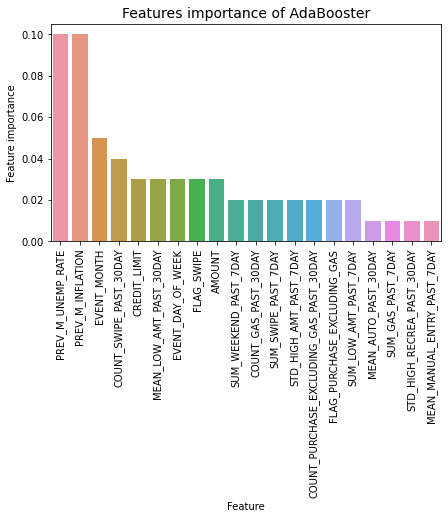

In [111]:
tmp = pd.DataFrame({'Feature': x_sub_train.columns.to_list(), 'Feature importance': abc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance of AdaBooster',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp.iloc[:20,:])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()